## Option pricing

Option pricing estimates the value of an option contract by estimating a price, known as a premium, based on stochastic model.

---

### Black-Scholes model

Given a stock $S(t)$ is modelled under the risk-neutral Geometric Brownian Motion (GBM) model, the Black-Scholes model allows to compute the theoretical value of an option contract for European options based on five input variables:

![](./img/bs-model-overview.png)

for which the dynamics of the stock and option value, under risk-neutral measure $\mathbb{Q}$, are given by

\begin{align}
	dS(t) &= r \cdot S(t) \cdot dt + \sigma \cdot S(t) \cdot dW^{\mathbb{Q}}(t),
	\\
	dV(t, S) &= \left( \frac{\partial V(t,S)} {\partial t} + r \frac{\partial V(t,S)} {\partial S} + \frac{1}{2}  \sigma^2 \frac{\partial^2 V(t,S)} {\partial S^2} \right)dt + \sigma  \frac{\partial V} {\partial S} dW^{\mathbb{Q}} ,
\end{align}

which yields the Black-Scholes pricing PDE

\begin{equation}
	\frac{dV(t, S)}{\partial t}  + rS \frac{\partial V(t,S)} {\partial S} + \sigma^2 \frac{\partial^2 V(t,S)} {\partial S^2} - rV(t,S) = 0,
\end{equation}

with a terminal condition $V(T, S) = H(T, S)$ specified by some payoff function $H(T, S)$ at time $T$, based on whether the type of the option contract (CALL or PUT).

The **Feynman-Kac theorem** allows to express the solution to a PDE with a terminal condition (in this case the Black-Scholes pricing PDE) in terms of an expectation

\begin{equation}
	V(t) = e^{-r(T-t)} \cdot \mathbb{E}^{\mathbb{Q}} [H(T,S) | \mathcal{F}(t)],
\end{equation}

where the expectation can be solved using simulation or integration. An analytical solution is then given by

\begin{equation}\begin{split}
	V_{c}(t,S)  & = S(t)F_{\mathcal{N(0,1)}}(d_1) - Ke^{-r(T-t)}F_{\mathcal{N(0,1)}}(d_2),
	\\
	V_{p}(t,S)  & = Ke^{-r(T-t)}F_{\mathcal{N(0,1)}}(-d_2) - S(t)F_{\mathcal{N(0,1)}}(-d_{1}),
\end{split}\end{equation}

with

\begin{equation}
	d_1 = \frac{ \log\frac{S(t)}{K} + (r + \frac{1}{2} \sigma^2)(T-t)}{\sigma \sqrt{T-t}} \quad, \quad d_2 = d_1 - \sigma \sqrt{T-t}.
\end{equation}

In the [`pyfin.black_scholes` module](../pyfin/black_scholes.py), two methods are implemented for option pricing: analytical and numerical, respectively `bs()` and `bs_num`(), both of which take the similar inputs and return an estimated option price.

The analytical method utilizes the analytical Feynman-Kac solution given by $(5)$. The numerical method computes $n$ number of stock prices at expiration, given by

\begin{equation}
	S(t) = S_0 \cdot \exp{((r - 1/2 \cdot \sigma^2) \cdot (t - t_0) + \sigma \cdot (W^{\mathbb{Q}}(t) - W^{\mathbb{Q}}(t_0)))}
\end{equation}

thus not needing simulate the timesteps inbetween expiration. The option price is then estimated as given by $(4)$ using the discounted mean of the payoff of the simulated stock prices.

The two methods are compared accross different strike prices, where the numerical method is furhter compared accross the number of paths $n$ used in simulation of the GBM.

In [1]:
%run ./config/setup.py
from pyfin.black_scholes import bs, bs_num

# parameters

s0 = 100
r = 0.05
sigma = 0.1
T = 1
K = range(80, 110, 1)

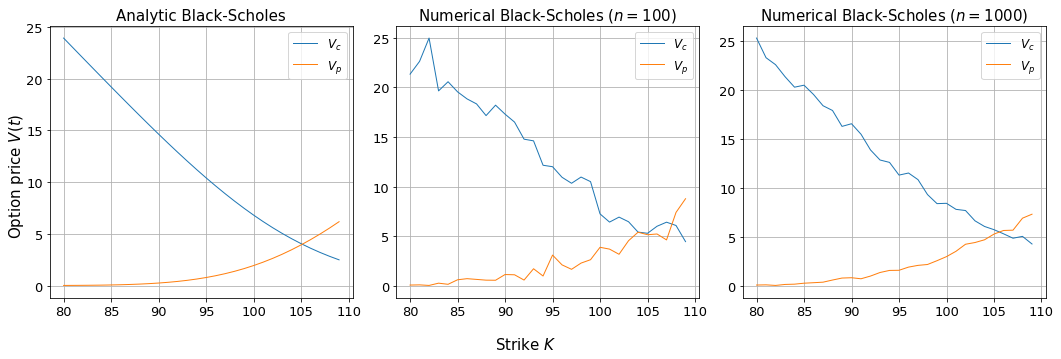

In [2]:
# plot

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

Vc = [bs(option_type="CALL", s0=s0, K=k, r=r, sigma=sigma, T=T) for k in K]
Vp = [bs(option_type="PUT", s0=s0, K=k, r=r, sigma=sigma, T=T) for k in K]
axs[0].plot(K, Vc, label=r"$V_c$")
axs[0].plot(K, Vp, label=r"$V_p$")
axs[0].set_title("Analytic Black-Scholes")

Vc = [bs_num(option_type="CALL", s0=s0, K=k, r=r, sigma=sigma, T=T, num_paths=100) for k in K]
Vp = [bs_num(option_type="PUT", s0=s0, K=k, r=r, sigma=sigma, T=T, num_paths=100) for k in K]
axs[1].plot(K, Vc, label=r"$V_c$")
axs[1].plot(K, Vp, label=r"$V_p$")
axs[1].set_title(r"Numerical Black-Scholes ($n=100$)")

Vc = [bs_num(option_type="CALL", s0=s0, K=k, r=r, sigma=sigma, T=T, num_paths=1000) for k in K]
Vp = [bs_num(option_type="PUT", s0=s0, K=k, r=r, sigma=sigma, T=T, num_paths=1000) for k in K]
axs[2].plot(K, Vc, label=r"$V_c$")
axs[2].plot(K, Vp, label=r"$V_p$")
axs[2].set_title(r"Numerical Black-Scholes ($n=1000$)")

for ax in axs.flat:
	ax.legend()
	ax.grid()
fig.supylabel(r"Option price $V(t)$"); fig.supxlabel(r"Strike $K$");

---

### Merton model (jump diffusion)

For a stock process $X(t) = \log{S(t)}$, the Arithmetic Brownian Motion with Jumps is modelled as

\begin{equation}
	dX(t) = (r - \xi_p \cdot \mathbb{E}[e^{J(t)} - 1] - \frac{1}{2} \cdot \sigma^2) dt + \sigma dW^{\mathbb{Q}}(t) + J(t) \cdot dX^{\mathbb{Q}}_{\mathcal{P}}(t)),
\end{equation}

driven by a Poisson process $dX^{\mathbb{Q}}_{\mathcal{P}}(t)$ with an **intensity** $\xi_p$ which indicates the average time between jumps (i.e., spacing of the jumps), such that the exepcted number of events is given by $\mathbb{E}[X^{\mathbb{Q}}_{\mathcal{P}}(t)] = \xi_p \cdot dt$, for a time interval $dt$. The **stochastic jump magnitude** $J(t)$ is normally distributed $J(t) \sim \mathcal{N}(\mu_J, \sigma_J)$. The model is then parameterized by $[r, \sigma, \mu_J, \sigma_J, \xi_p]$, which can be calibrated using historical data. Given that $J(t)$ is normally distributed, calculation of $\mathbb{E}[e^{J(t)} - 1])$ is given by $\exp{(\mu_J \cdot \frac{\sigma_J^2}{2})} - 1$.

The [`pyfin.sde` module](../pyfin/sde.py) module implements the `merton()` method for simulation of Merton model.

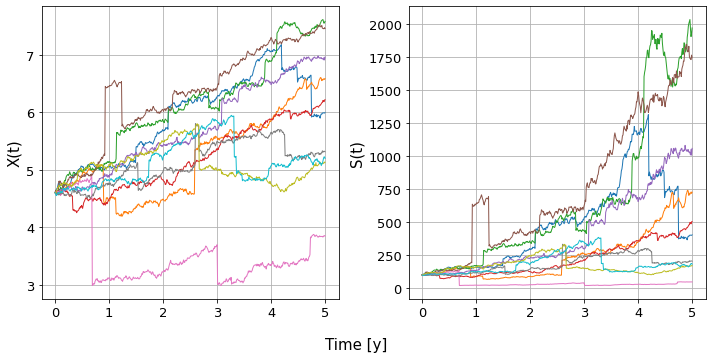

In [3]:
from pyfin.sde import merton

t, S, X = merton(s0=100, r=0.5, sigma=0.2, mu_J=0, sigma_J=0.5, xi_p=1, T=5, reproducible=True)

# plot

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].plot(t, X.T)
axs[0].set_ylabel("X(t)")

axs[1].plot(t, S.T)
axs[1].set_ylabel("S(t)")

for ax in axs.flat:
	ax.ticklabel_format(useOffset=False, style="plain")
	ax.grid()
fig.supxlabel("Time [y]");

Option pricing using the Merton model can be performed using the analytical solution (given by $(5.28)$ in BOOK) or using the COS method (given the charachteristic function of the Merton model).

The COS method uses an iterative expansion (adding extra terms to a sum like Taylor series, where more terms equals better approximation) in which density recovery is achieved by replacing the den-sity by its Fourier-cosine series expansion.

Given $x := X(t) = \log{S(t)}$ and $y := X(T)$, the value of a plain vanilla European option under the Merton model is given by

\begin{equation}
V\left(t_0,x\right)=e^{-e\tau}\cdot\mathbb{E}\left[V\left(T,y\right)\ |\ \mathcal{F}\left(t_0\right)\right]=e^{-r\tau}\cdot\int_{\mathbb{R}}{V\left(T,y\right)\cdot f_X\left(T,y;t_0,x\right)\ dy}
\end{equation}

where $\tau=T - t_0$, and $f_X(T,y;t_0,x) = f_X(y)$ is the transition probability density of $X(T)$ (from $t_0 \rightarrow T$) and is thus dependent on the parameters of the stochastic process $X(t)$.

An approximation is, in summary, given by: (1) truncating the integration domain, (2) approximating the probability density function using Fourier series-expansion, and (3) interchanging the integral and summation in term of cosine series coefficients of the payoff function, which are solved analytically. The option value is then given by

\begin{equation}
	V(t_0, x) = e^{-r \tau} \cdot \sum_{k=0}^{N-1}{}^{'} \text{Re} \left\{ \phi_X \left(\frac{k \pi}{b - a} \right) \exp \left(-ik\pi \frac{a}{b - a} \right)\right\} \cdot H_k
\end{equation}

where $N$ is the number of expansion terms, $\Sigma^{'}(\cdot)$ is a summation in which the first term is halfed, $\phi_X(u; x, t, T)$ is the charachteristic function, and $H_k$ are the cosine series coefficients of the payoff function.

In the [`pyfin.merton` module](../pyfin/merton.py), the `merton()` method implements the analytical solution, whereas the `merton_cos()` method implmenents the COS-based solution, using the helper functions `merton_chf()` and `merton_H_k()`. The two methods are compared in a similar way to the Black-Schole implementation, using the same base parameters, also comparing two different values of $N$ (number of Fourier series summation terms).

In [4]:
from pyfin.merton import merton, merton_cos

# parameters

s0 = 100
r = 0.05
sigma = 0.1
mu_J = 0
sigma_J = 0.5
xi_p = 1
T = 1
K = range(80, 110, 1)
L = 8
a, b = (-L * sqrt(T), L * sqrt(T))


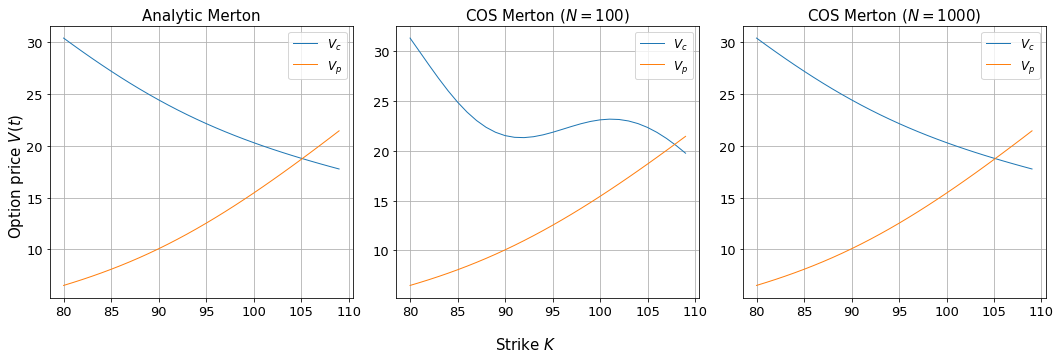

In [5]:
# plot

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

Vc = [merton(option_type="CALL", s0=s0, r=r, sigma=sigma, mu_J=mu_J, sigma_J=sigma_J, xi_p=xi_p, K=k, T=T) for k in K]
Vp = [merton(option_type="PUT", s0=s0, r=r, sigma=sigma, mu_J=mu_J, sigma_J=sigma_J, xi_p=xi_p, K=k, T=T) for k in K]
axs[0].plot(K, Vc, label=r"$V_c$")
axs[0].plot(K, Vp, label=r"$V_p$")
axs[0].set_title("Analytic Merton")

Vc = [merton_cos(option_type="CALL", s0=s0, r=r, sigma=sigma, mu_J=mu_J, sigma_J=sigma_J, xi_p=xi_p, K=k, T=T, a=a, b=b, N=100) for k in K]
Vp = [merton_cos(option_type="PUT", s0=s0, r=r, sigma=sigma, mu_J=mu_J, sigma_J=sigma_J, xi_p=xi_p, K=k, T=T, a=a, b=b, N=100) for k in K]
axs[1].plot(K, Vc, label=r"$V_c$")
axs[1].plot(K, Vp, label=r"$V_p$")
axs[1].set_title(r"COS Merton ($N=100$)")

Vc = [merton_cos(option_type="CALL", s0=s0, r=r, sigma=sigma, mu_J=mu_J, sigma_J=sigma_J, xi_p=xi_p, K=k, T=T, a=a, b=b, N=1000) for k in K]
Vp = [merton_cos(option_type="PUT", s0=s0, r=r, sigma=sigma, mu_J=mu_J, sigma_J=sigma_J, xi_p=xi_p, K=k, T=T, a=a, b=b, N=1000) for k in K]
axs[2].plot(K, Vc, label=r"$V_c$")
axs[2].plot(K, Vp, label=r"$V_p$")
axs[2].set_title(r"COS Merton ($N=1000$)")

for ax in axs.flat:
	ax.legend()
	ax.grid()
fig.supylabel(r"Option price $V(t)$"); fig.supxlabel(r"Strike $K$");

---

### Heston model

The Heston model is a **stochastic volatility model** for pricing of European options, which models the volatility $\sigma(t)$ as a random process with the following properties:

- It factors in a possible correlation between a stock's price and its volatility.
- It conveys volatility as reverting to the mean.
- It does not require that stock prices follow a lognormal probability distribution.

The model is defined by two correlated stochastic differential equations under risk neutral measure $\mathbb{Q}$, namely: (1) the underlying asset price $S(t)$, and (2) the variance process $v(t)$, as

\begin{equation}
	\left\{\begin{matrix}dS\left(t\right)=rS\left(t\right)dt+\sqrt{v\left(t\right)}\cdot S\left(t\right)\cdot d W_x^\mathbb{Q}\left(t\right)\\dv\left(t\right)=\kappa\left(\bar{v}-v\left(t\right)\right)dt+\gamma\sqrt{v\left(t\right)}\cdot d W_v^\mathbb{Q}\left(t\right)\\\end{matrix}\right.
\end{equation}

in which the variance process $v(t)$ is driven by a CIR process.

The Heston model can be written in terms of **independent Brownian motions**, as


\begin{equation}
	\left[\begin{matrix}dS(t)\\dv(t)\\\end{matrix}\right]=\left[\begin{matrix}r\cdot S(t)\\\kappa\left(\bar{v}-v\left(t\right)\right)\\\end{matrix}\right]dt+\sqrt{v\left(t\right)}\cdot\left[\begin{matrix}S\left(t\right)&0\\\gamma\cdot\rho_{x,v}&\gamma\cdot\sqrt{1-\rho_{x,v}^2}\\\end{matrix}\ \right]\ \left[\begin{matrix}d{\widetilde{W}}_x^\mathbb{Q}\left(t\right)\\d{\widetilde{W}}_v^\mathbb{Q}\left(t\right)\\\end{matrix}\right]
\end{equation}

such that the Heston model depends on  $[S_0, v_0] > 0$. and is parameterized by $[r, \bar{v}, \kappa, \gamma, \rho_{x, v}]$, being the interest rate, long-term mean of the variance process, speed of mean reversion, volatility of the volatility (vol-vol), and the correlation between the two processes (typically negative), respectively.

The [`pyfin.sde` module](../pyfin/sde.py) module implements the `heston()` method for simulation of Merton model.

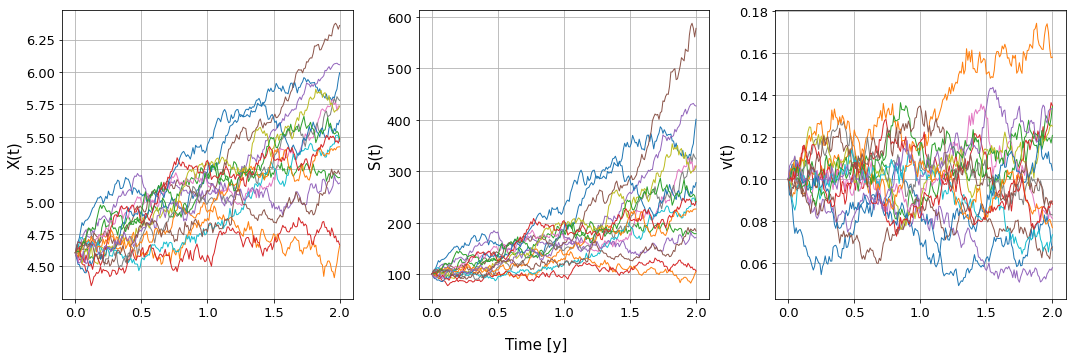

In [27]:
from pyfin.sde import heston

t, S, X, V = heston(s0=100, r=0.5, v0=0.1, v_bar=0.1, kappa=0.5, gamma=0.1, rho=-0.75, T=2, num_paths=16, reproducible=True)

# plot

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].plot(t, X.T)
axs[0].set_ylabel("X(t)")

axs[1].plot(t, S.T)
axs[1].set_ylabel("S(t)")

axs[2].plot(t, V.T)
axs[2].set_ylabel("v(t)")

for ax in axs.flat:
	ax.ticklabel_format(useOffset=False, style="plain")
	ax.grid()
fig.supxlabel("Time [y]");